In [24]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import os
import torch

from torch.utils.data import DataLoader

In [25]:
from dataHandler.dataset import MHDProjDataset,LogNormalTransform

In [26]:
from validationMetrics.powerSpectrum import power_spectrum_iso, plot_ps
from validationMetrics.minkowskiFunctional import plot_mink_functionals

In [27]:
from ddpm.model import TinyUNet
from ddpm.diffusion import DDPM, generate_image

In [28]:
### Experimental set-up
SOURCE_DIR='/mnt/home/dheurtel/ceph/00_exploration_data/density/b_proj'

SAMPLE_FOLDER='/mnt/home/dheurtel/ceph/20_samples/artificial_architecture_exps/'  #For periodic samples
CKPT_FOLDER='/mnt/home/dheurtel/ceph/10_checkpoints/artificial_architecture_exps/' #For checkpoints and losses

In [29]:
exps=os.listdir(SAMPLE_FOLDER)
exps.sort()
exps

['MHD_DDPM_BN_bottleneck16_dens',
 'MHD_DDPM_BN_bottleneck16_toy',
 'MHD_DDPM_BN_bottleneck32_dens',
 'MHD_DDPM_BN_bottleneck32_toy',
 'MHD_DDPM_BN_bottleneck8_dens',
 'MHD_DDPM_BN_bottleneck8_toy',
 'MHD_DDPM_DN_bottleneck16_dens',
 'MHD_DDPM_DN_bottleneck16_toy',
 'MHD_DDPM_DN_bottleneck32_dens',
 'MHD_DDPM_DN_bottleneck32_toy',
 'MHD_DDPM_DN_bottleneck8_dens',
 'MHD_DDPM_DN_bottleneck8_toy',
 'MHD_DDPM_GN_bottleneck16_dens',
 'MHD_DDPM_GN_bottleneck16_toy',
 'MHD_DDPM_GN_bottleneck32_dens',
 'MHD_DDPM_GN_bottleneck32_toy',
 'MHD_DDPM_GN_bottleneck8_dens',
 'MHD_DDPM_GN_bottleneck8_toy',
 'MHD_DDPM_LN_bottleneck16_dens',
 'MHD_DDPM_LN_bottleneck16_toy',
 'MHD_DDPM_LN_bottleneck32_dens',
 'MHD_DDPM_LN_bottleneck32_toy',
 'MHD_DDPM_LN_bottleneck8_dens',
 'MHD_DDPM_LN_bottleneck8_toy',
 'MHD_DDPM_None_bottleneck16_dens',
 'MHD_DDPM_None_bottleneck16_toy',
 'MHD_DDPM_None_bottleneck32_dens',
 'MHD_DDPM_None_bottleneck32_toy',
 'MHD_DDPM_None_bottleneck8_dens',
 'MHD_DDPM_None_bottleneck8

**Chose now the experiments ID you want to check**

(Baselines are LN/32/dens and LN/32/toy)

In [30]:
SIZE=256
N_STEPS=1000
BATCH_SIZE=64

MODEL_ID1='MHD_DDPM_None_bottleneck32_dens'

SAMPLE_BATCH_SIZE1=16
RESULT_SAMPLE_SIZE1=256

SAMPLE_STEP_EPOCH1=200

NUM_EPOCHS1=5000

MODEL_ID2='MHD_DDPM_None_bottleneck8_dens'

SAMPLE_BATCH_SIZE2=16
RESULT_SAMPLE_SIZE2=256

SAMPLE_STEP_EPOCH2=200

NUM_EPOCHS2=5000

In [31]:
dataset=MHDProjDataset(SOURCE_DIR,random_rotate=True,transforms=LogNormalTransform(),test_batch_length=95)

In [32]:
l1=os.listdir(os.path.join(SAMPLE_FOLDER,MODEL_ID1))
l1.sort()
l_results1=l1[:RESULT_SAMPLE_SIZE1]
l_samples1=l1[RESULT_SAMPLE_SIZE1:]

l2=os.listdir(os.path.join(SAMPLE_FOLDER,MODEL_ID2))
l2.sort()
l_results2=l2[:RESULT_SAMPLE_SIZE1]
l_samples2=l2[RESULT_SAMPLE_SIZE1:]

In [33]:
n_epoch_sampled1=len(l_samples1)//SAMPLE_BATCH_SIZE1
n_epoch_sampled2=len(l_samples2)//SAMPLE_BATCH_SIZE2


In [34]:
data1=[np.load(os.path.join(SAMPLE_FOLDER,MODEL_ID1,l_results1[i]),allow_pickle=True) for i in range(RESULT_SAMPLE_SIZE1)]
data1=np.concatenate(data1)
data2=[np.load(os.path.join(SAMPLE_FOLDER,MODEL_ID2,l_results2[i]),allow_pickle=True) for i in range(RESULT_SAMPLE_SIZE2)]
data2=np.concatenate(data2)
data1.shape, data2.shape

((256, 256, 256), (256, 256, 256))

In [35]:
source_data_partial=np.concatenate([dataset[i].reshape(1,SIZE,SIZE) for i in range(256)])

In [88]:
toy_dataset=MHDProjDataset('/mnt/home/dheurtel/ceph/00_exploration_data/toy/',random_rotate=True,transforms=LogNormalTransform(),test_batch_length=95)

In [89]:
source_data_partial_toy=np.concatenate([toy_dataset[i].reshape(1,SIZE,SIZE) for i in range(256)])

In [36]:
amin,amax=(-6.232629, 7.390278)

**Summary statistics computation and visualisation**

*Basics*

In [37]:
print(np.min(data1),np.max(data1))
print(np.min(data2),np.max(data2))
print(np.min(source_data_partial),np.max(source_data_partial))

-3.5633585 4.924235
-22.845913 12.479677
-4.676987 5.310774


In [38]:
hist_data=np.histogram(source_data_partial.flatten(), bins=100, density=True)
hist_1=np.histogram(data1.flatten(), bins=100, density=True)
hist_2=np.histogram(data2.flatten(), bins=100, density=True)

bins1=np.array([(hist_1[1][i]+hist_1[1][i+1])/2 for i in range(100)])
bins2=np.array([(hist_2[1][i]+hist_2[1][i+1])/2 for i in range(100)])
bins=np.array([(hist_data[1][i]+hist_data[1][i+1])/2 for i in range(100)])

n1=data1.size
n2=data2.size
n=source_data_partial.size

In [39]:
bins1.shape,hist_1[0].shape

((100,), (100,))

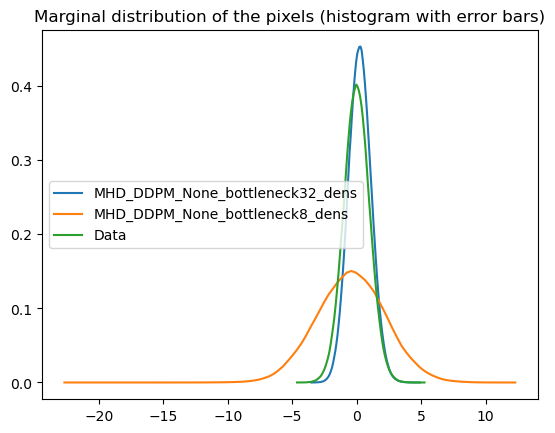

In [40]:
plt.plot(bins1,hist_1[0], label=MODEL_ID1)
plt.fill_between(bins1, hist_1[0]-np.sqrt(hist_1[0]*(1-hist_1[0])/n1),hist_1[0]+np.sqrt(hist_1[0]*(1-hist_1[0])/n1),alpha=0.25)
plt.plot(bins2,hist_2[0], label=MODEL_ID2)
plt.fill_between(bins2, hist_2[0]-np.sqrt(hist_2[0]*(1-hist_2[0])/n1),hist_2[0]+np.sqrt(hist_2[0]*(1-hist_2[0])/n1),alpha=0.25)
plt.plot(bins,hist_data[0], label='Data')
plt.fill_between(bins, hist_data[0]-np.sqrt(hist_data[0]*(1-hist_data[0])/n1),hist_data[0]+np.sqrt(hist_data[0]*(1-hist_data[0])/n1),alpha=0.25)
plt.title('Marginal distribution of the pixels (histogram with error bars)')
plt.legend()

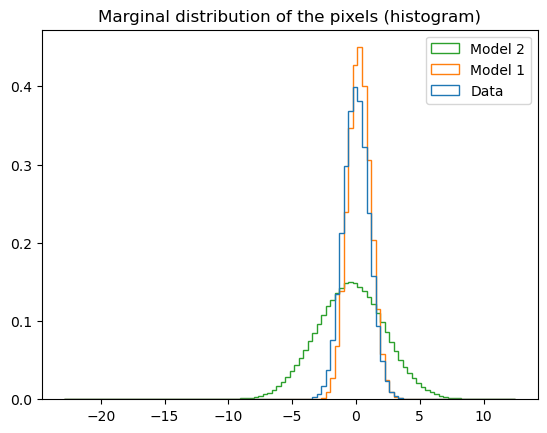

In [41]:
##Mean, STD, HIST pixel per pixel

plt.hist([source_data_partial.flatten(),data1.flatten(),data2.flatten()],label=['Data','Model 1','Model 2'],density=True,histtype='step',bins=100)
plt.title('Marginal distribution of the pixels (histogram)')
plt.legend()
plt.show()

In [42]:
def wasserstein(arr1,arr2):
    mean1, std1= np.mean(arr1), np.std(arr1)
    mean2, std2= np.mean(arr2), np.std(arr2)
    return (mean2-mean1)**2+(std1+std2-2*np.sqrt(std2*std1))

In [43]:
wasserstein(source_data_partial, data1), wasserstein(source_data_partial, data2)

(0.06721408756864466, 0.5830681572241128)

In [44]:
np_intermediate_samples1=[np.concatenate([np.load(os.path.join(SAMPLE_FOLDER,MODEL_ID1,l_samples1[i+SAMPLE_BATCH_SIZE1*j]),allow_pickle=True) for i in range(SAMPLE_BATCH_SIZE1)]) for j in range(n_epoch_sampled1)]
np_intermediate_samples2=[np.concatenate([np.load(os.path.join(SAMPLE_FOLDER,MODEL_ID2,l_samples2[i+SAMPLE_BATCH_SIZE2*j]),allow_pickle=True) for i in range(SAMPLE_BATCH_SIZE2)]) for j in range(n_epoch_sampled2)]

In [45]:
np_intermediate_pixels1=[arr.flatten() for arr in np_intermediate_samples1]
np_intermediate_pixels2=[arr.flatten() for arr in np_intermediate_samples2]

In [46]:
hist_todo1=np_intermediate_pixels1[3::2]+[source_data_partial.flatten()]
labels1=['epoch_'+str(SAMPLE_STEP_EPOCH1*i) for i in range(3,n_epoch_sampled1,2)]+['source data']

hist_todo2=np_intermediate_pixels2[3::2]+[source_data_partial.flatten()]
labels2=['epoch_'+str(SAMPLE_STEP_EPOCH2*i) for i in range(3,n_epoch_sampled2,2)]+['source data']

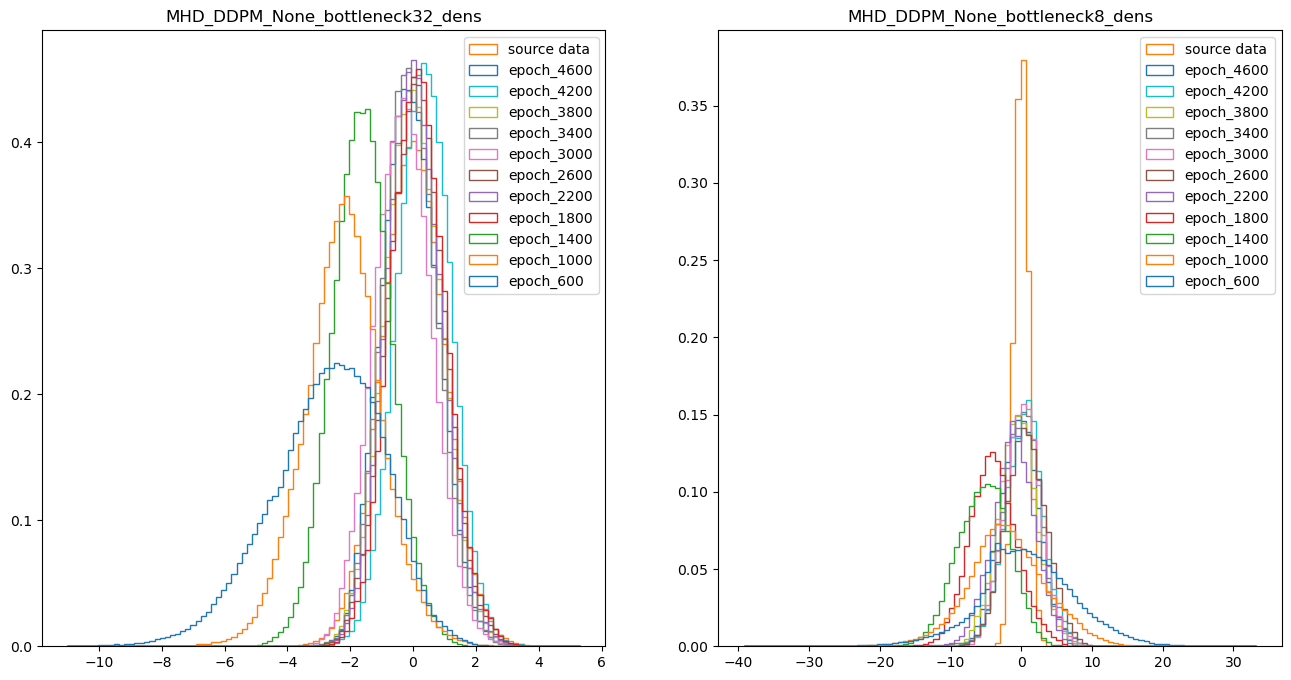

In [47]:
fig,ax= plt.subplots(1,2,figsize=(16,8))
ax[0].hist(hist_todo1,density=True,histtype='step',bins=100,label=labels1)
ax[1].hist(hist_todo2,density=True,histtype='step',bins=100,label=labels2)

ax[0].title.set_text(MODEL_ID1)
ax[1].title.set_text(MODEL_ID2)

ax[0].legend()
ax[1].legend()
plt.show()

In [48]:
wass_2=[wasserstein(source_data_partial, np_intermediate_pixels2_epoch) for np_intermediate_pixels2_epoch in np_intermediate_pixels2]

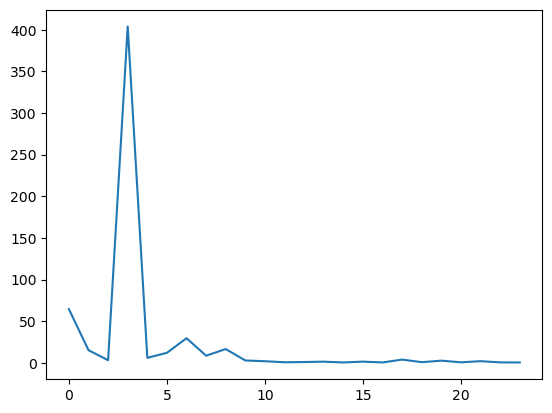

In [49]:
plt.plot(wass_2[1:])

*Power Spectrum*

In [50]:
x1=data1[0]
x2=data2[0]

In [51]:
bins = np.linspace(0, np.pi, 100)
_, ps_x1, _ = power_spectrum_iso(x1, bins=bins)
bins, ps_x2, _ = power_spectrum_iso(x2, bins=bins)

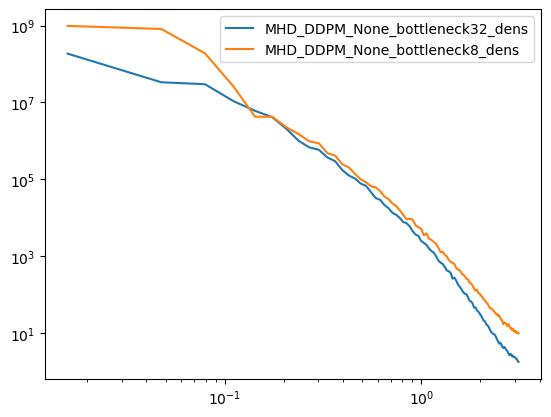

In [52]:
plot_ps(bins, [ps_x1,ps_x2], labels=[MODEL_ID1,MODEL_ID2],show=True)

In [53]:
xdata=(np.log(np.load(os.path.join(SOURCE_DIR,'dens_t0895.fits.gz.npy')))-5.5)/0.3

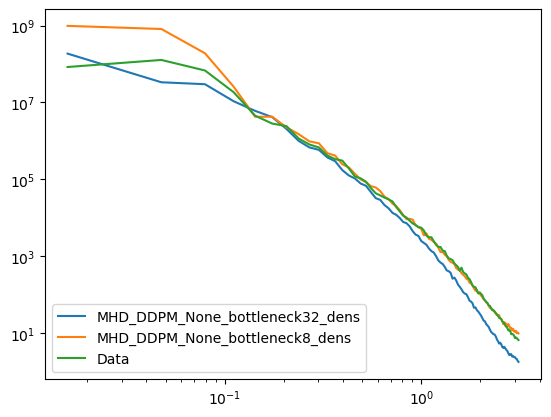

In [54]:
_, ps_xdata, _ = power_spectrum_iso(xdata, bins=bins)
plot_ps(bins, [ps_x1,ps_x2,ps_xdata], labels=[MODEL_ID1,MODEL_ID2,'Data'],show=True)

In [55]:
power_spectra1=np.concatenate([power_spectrum_iso(data_point,bins=bins)[1].reshape(1,100) for data_point in data1],axis=0)
power_spectra2=np.concatenate([power_spectrum_iso(data_point,bins=bins)[1].reshape(1,100) for data_point in data2],axis=0)

In [56]:
true_power_spectra=np.concatenate([power_spectrum_iso(data_point,bins=bins)[1].reshape(1,100) for data_point in source_data_partial],axis=0)

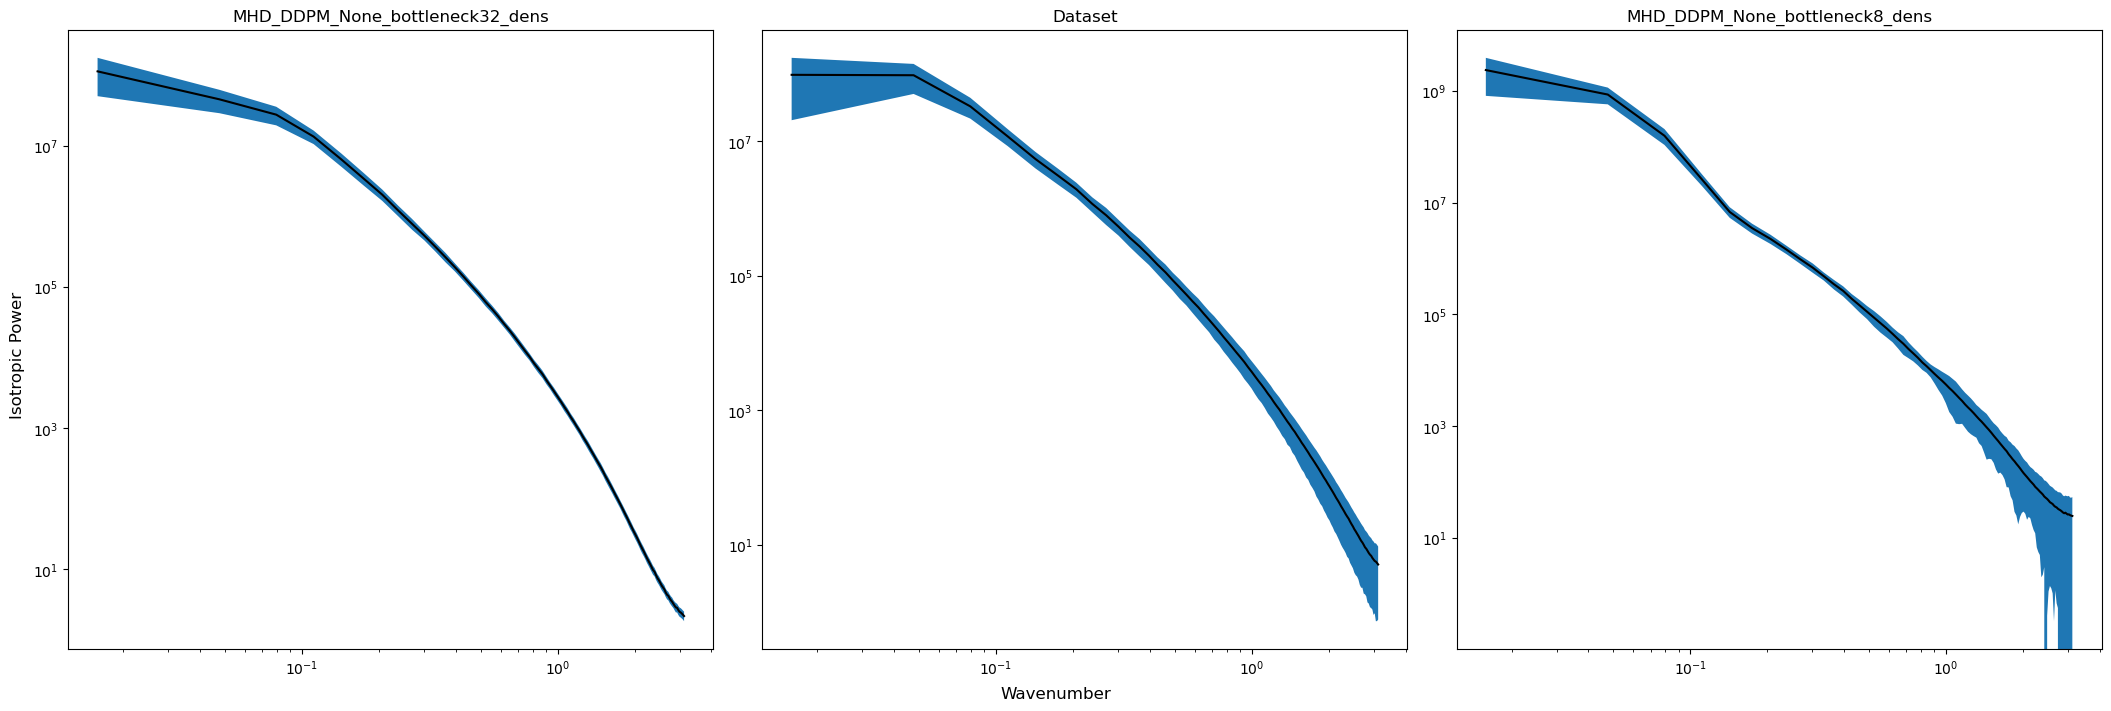

In [57]:
bins_centers = (bins[:-1] + bins[1:])/2
    
fig, ax = plt.subplots(1, 3,figsize=(21,7), layout='constrained')
mean1,std1=np.mean(power_spectra1,axis=0)[:99],np.std(power_spectra1,axis=0)[:99]
mean2,std2=np.mean(power_spectra2,axis=0)[:99],np.std(power_spectra2,axis=0)[:99]
true_mean,true_std=np.mean(true_power_spectra,axis=0)[:99],np.std(true_power_spectra,axis=0)[:99]

ax[0].plot(bins_centers,mean1,'-k')
ax[0].fill_between(bins_centers,mean1+std1,mean1-std1)

ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].title.set_text(MODEL_ID1)
fig.supylabel('Isotropic Power')
fig.supxlabel('Wavenumber')

ax[1].plot(bins_centers,true_mean,'-k')
ax[1].fill_between(bins_centers,true_mean+true_std,true_mean-true_std)

ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].title.set_text('Dataset')

ax[2].plot(bins_centers,mean2,'-k')
ax[2].fill_between(bins_centers,mean2+std2,mean2-std2)

ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[2].title.set_text(MODEL_ID2)

Text(0.5, 0.01, 'Wavenumber')

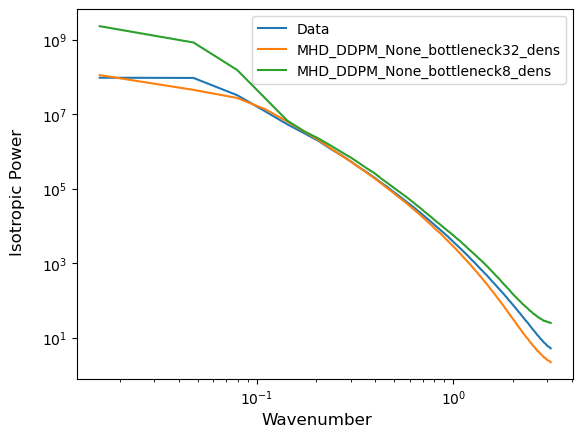

In [58]:
fig, ax = plt.subplots(1, 1)
ax.plot(bins_centers,true_mean,label='Data')
ax.plot(bins_centers,mean1,label=MODEL_ID1)
ax.plot(bins_centers,mean2,label=MODEL_ID2)
ax.set_xscale('log')
ax.set_yscale('log')

plt.legend()

fig.supylabel('Isotropic Power')
fig.supxlabel('Wavenumber')


*Minkowski functional*

In [59]:
l_np_data_partial=[datapoint for datapoint in source_data_partial]
l_np_results_partial1=[datapoint for datapoint in data1]
l_np_results_partial2=[datapoint for datapoint in data2]

In [60]:
tot=np.concatenate(l_np_data_partial+l_np_results_partial1+l_np_results_partial2)
RANGEMIN, RANGEMAX=-10,10

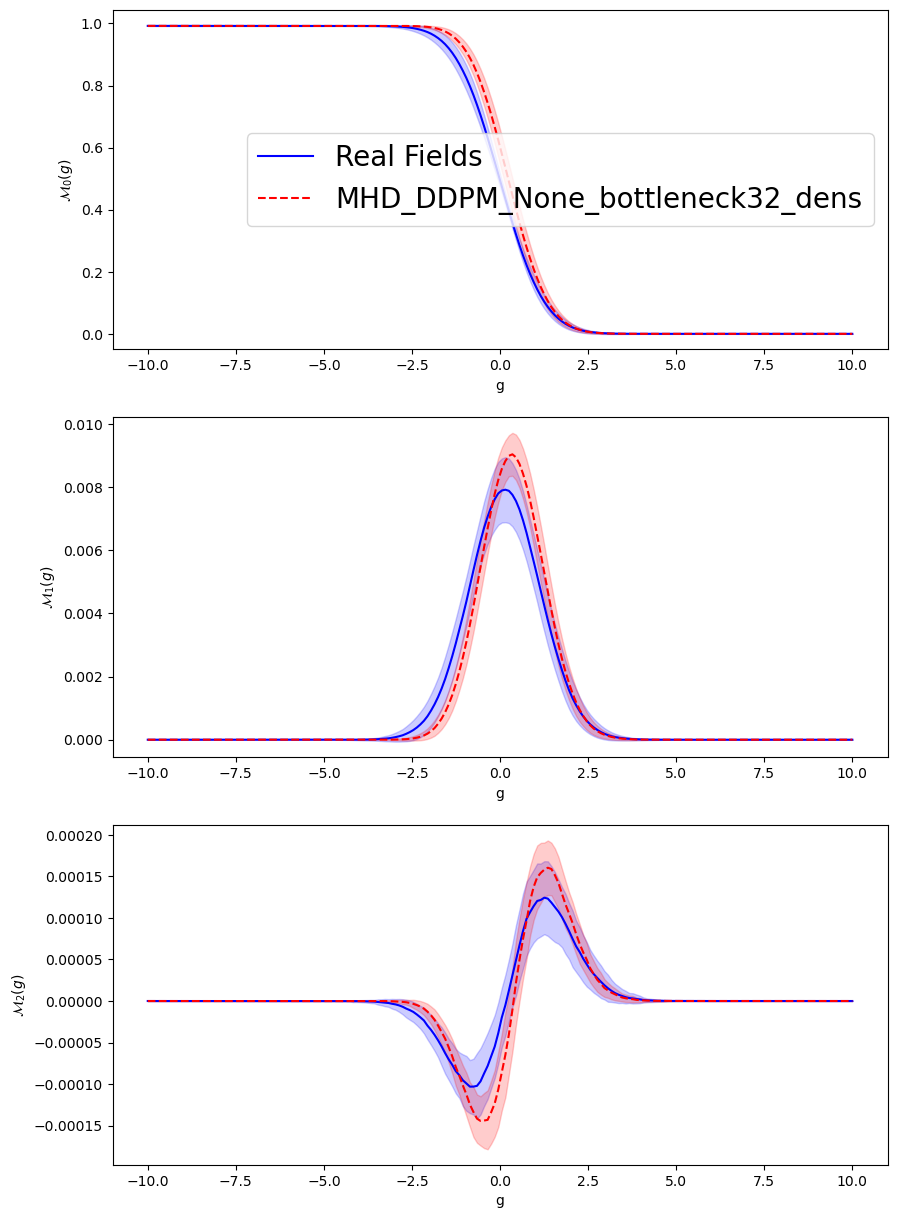

In [61]:
smm, sms=plot_mink_functionals([l_np_data_partial,l_np_results_partial1],gs_vals = np.linspace(RANGEMIN, RANGEMAX, 200),
                      names = ['Real Fields', MODEL_ID1], cols = ['b', 'r'], 
                      savefig_dict={})

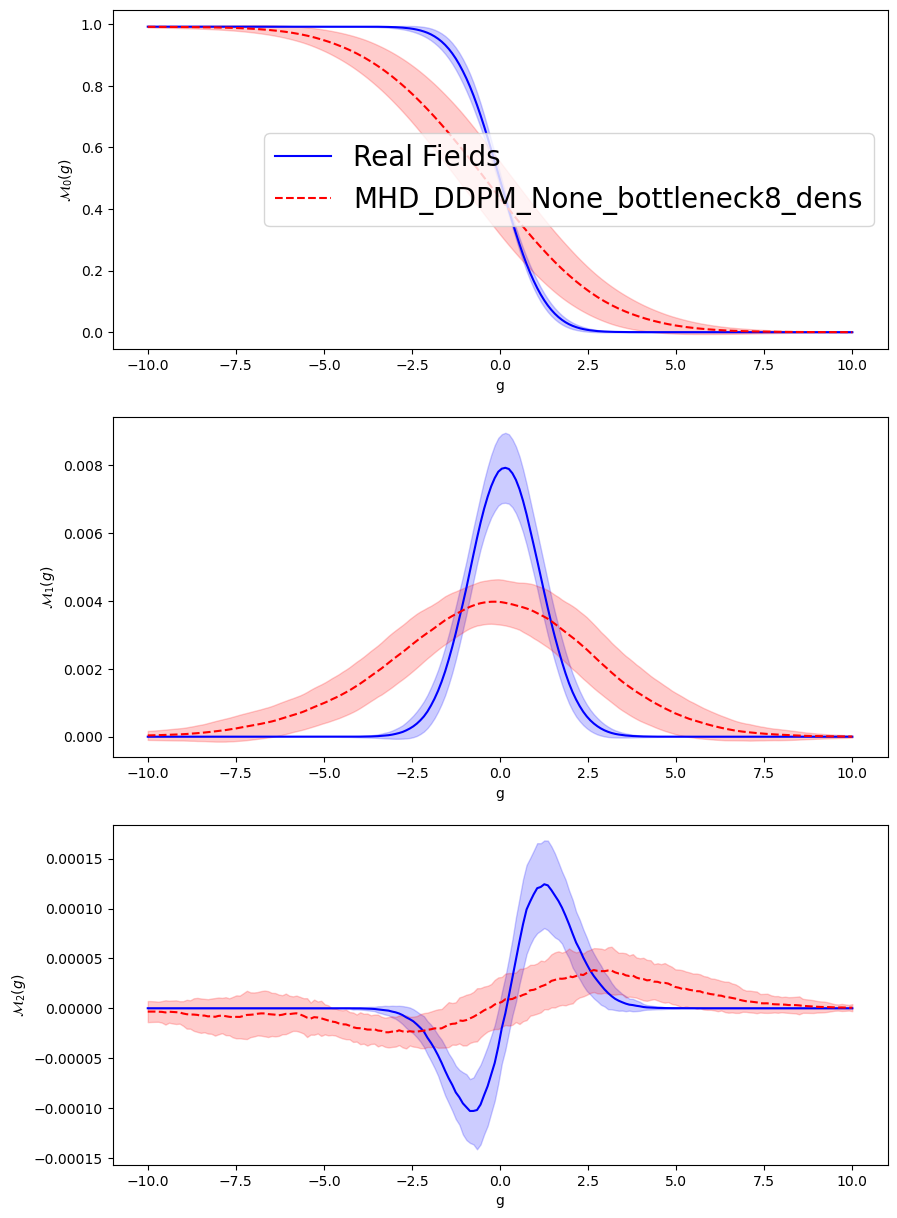

In [62]:
smm, sms=plot_mink_functionals([l_np_data_partial,l_np_results_partial2],gs_vals = np.linspace(RANGEMIN, RANGEMAX, 200),
                      names = ['Real Fields', MODEL_ID2], cols = ['b', 'r'], 
                      savefig_dict={})

In [79]:
def swap(l,n_swap=3):
    for i in range(len(l)//3):
        l[i*3:(i+1)*3] = l[i*3:(i+1)*3][1],l[i*3:(i+1)*3][0],l[i*3:(i+1)*3][2]
    

In [84]:
exps_to_check=[exp for exp in exps if 'toy' in exp]
exps_to_check

['MHD_DDPM_BN_bottleneck16_toy',
 'MHD_DDPM_BN_bottleneck32_toy',
 'MHD_DDPM_BN_bottleneck8_toy',
 'MHD_DDPM_DN_bottleneck16_toy',
 'MHD_DDPM_DN_bottleneck32_toy',
 'MHD_DDPM_DN_bottleneck8_toy',
 'MHD_DDPM_GN_bottleneck16_toy',
 'MHD_DDPM_GN_bottleneck32_toy',
 'MHD_DDPM_GN_bottleneck8_toy',
 'MHD_DDPM_LN_bottleneck16_toy',
 'MHD_DDPM_LN_bottleneck32_toy',
 'MHD_DDPM_LN_bottleneck8_toy',
 'MHD_DDPM_None_bottleneck16_toy',
 'MHD_DDPM_None_bottleneck32_toy',
 'MHD_DDPM_None_bottleneck8_toy']

In [85]:
swap(exps_to_check)
exps_to_check

['MHD_DDPM_BN_bottleneck32_toy',
 'MHD_DDPM_BN_bottleneck16_toy',
 'MHD_DDPM_BN_bottleneck8_toy',
 'MHD_DDPM_DN_bottleneck32_toy',
 'MHD_DDPM_DN_bottleneck16_toy',
 'MHD_DDPM_DN_bottleneck8_toy',
 'MHD_DDPM_GN_bottleneck32_toy',
 'MHD_DDPM_GN_bottleneck16_toy',
 'MHD_DDPM_GN_bottleneck8_toy',
 'MHD_DDPM_LN_bottleneck32_toy',
 'MHD_DDPM_LN_bottleneck16_toy',
 'MHD_DDPM_LN_bottleneck8_toy',
 'MHD_DDPM_None_bottleneck32_toy',
 'MHD_DDPM_None_bottleneck16_toy',
 'MHD_DDPM_None_bottleneck8_toy']

In [86]:
data1=[np.load(os.path.join(SAMPLE_FOLDER,MODEL_ID1,l_results1[i]),allow_pickle=True) for i in range(RESULT_SAMPLE_SIZE1)]
data1=np.concatenate(data1)

In [87]:
total_samples_data=[np.concatenate([np.load(os.path.join(SAMPLE_FOLDER,MODEL_ID,l_results1[i]), allow_pickle=True) for i in range(RESULT_SAMPLE_SIZE1)]) for MODEL_ID in exps_to_check]

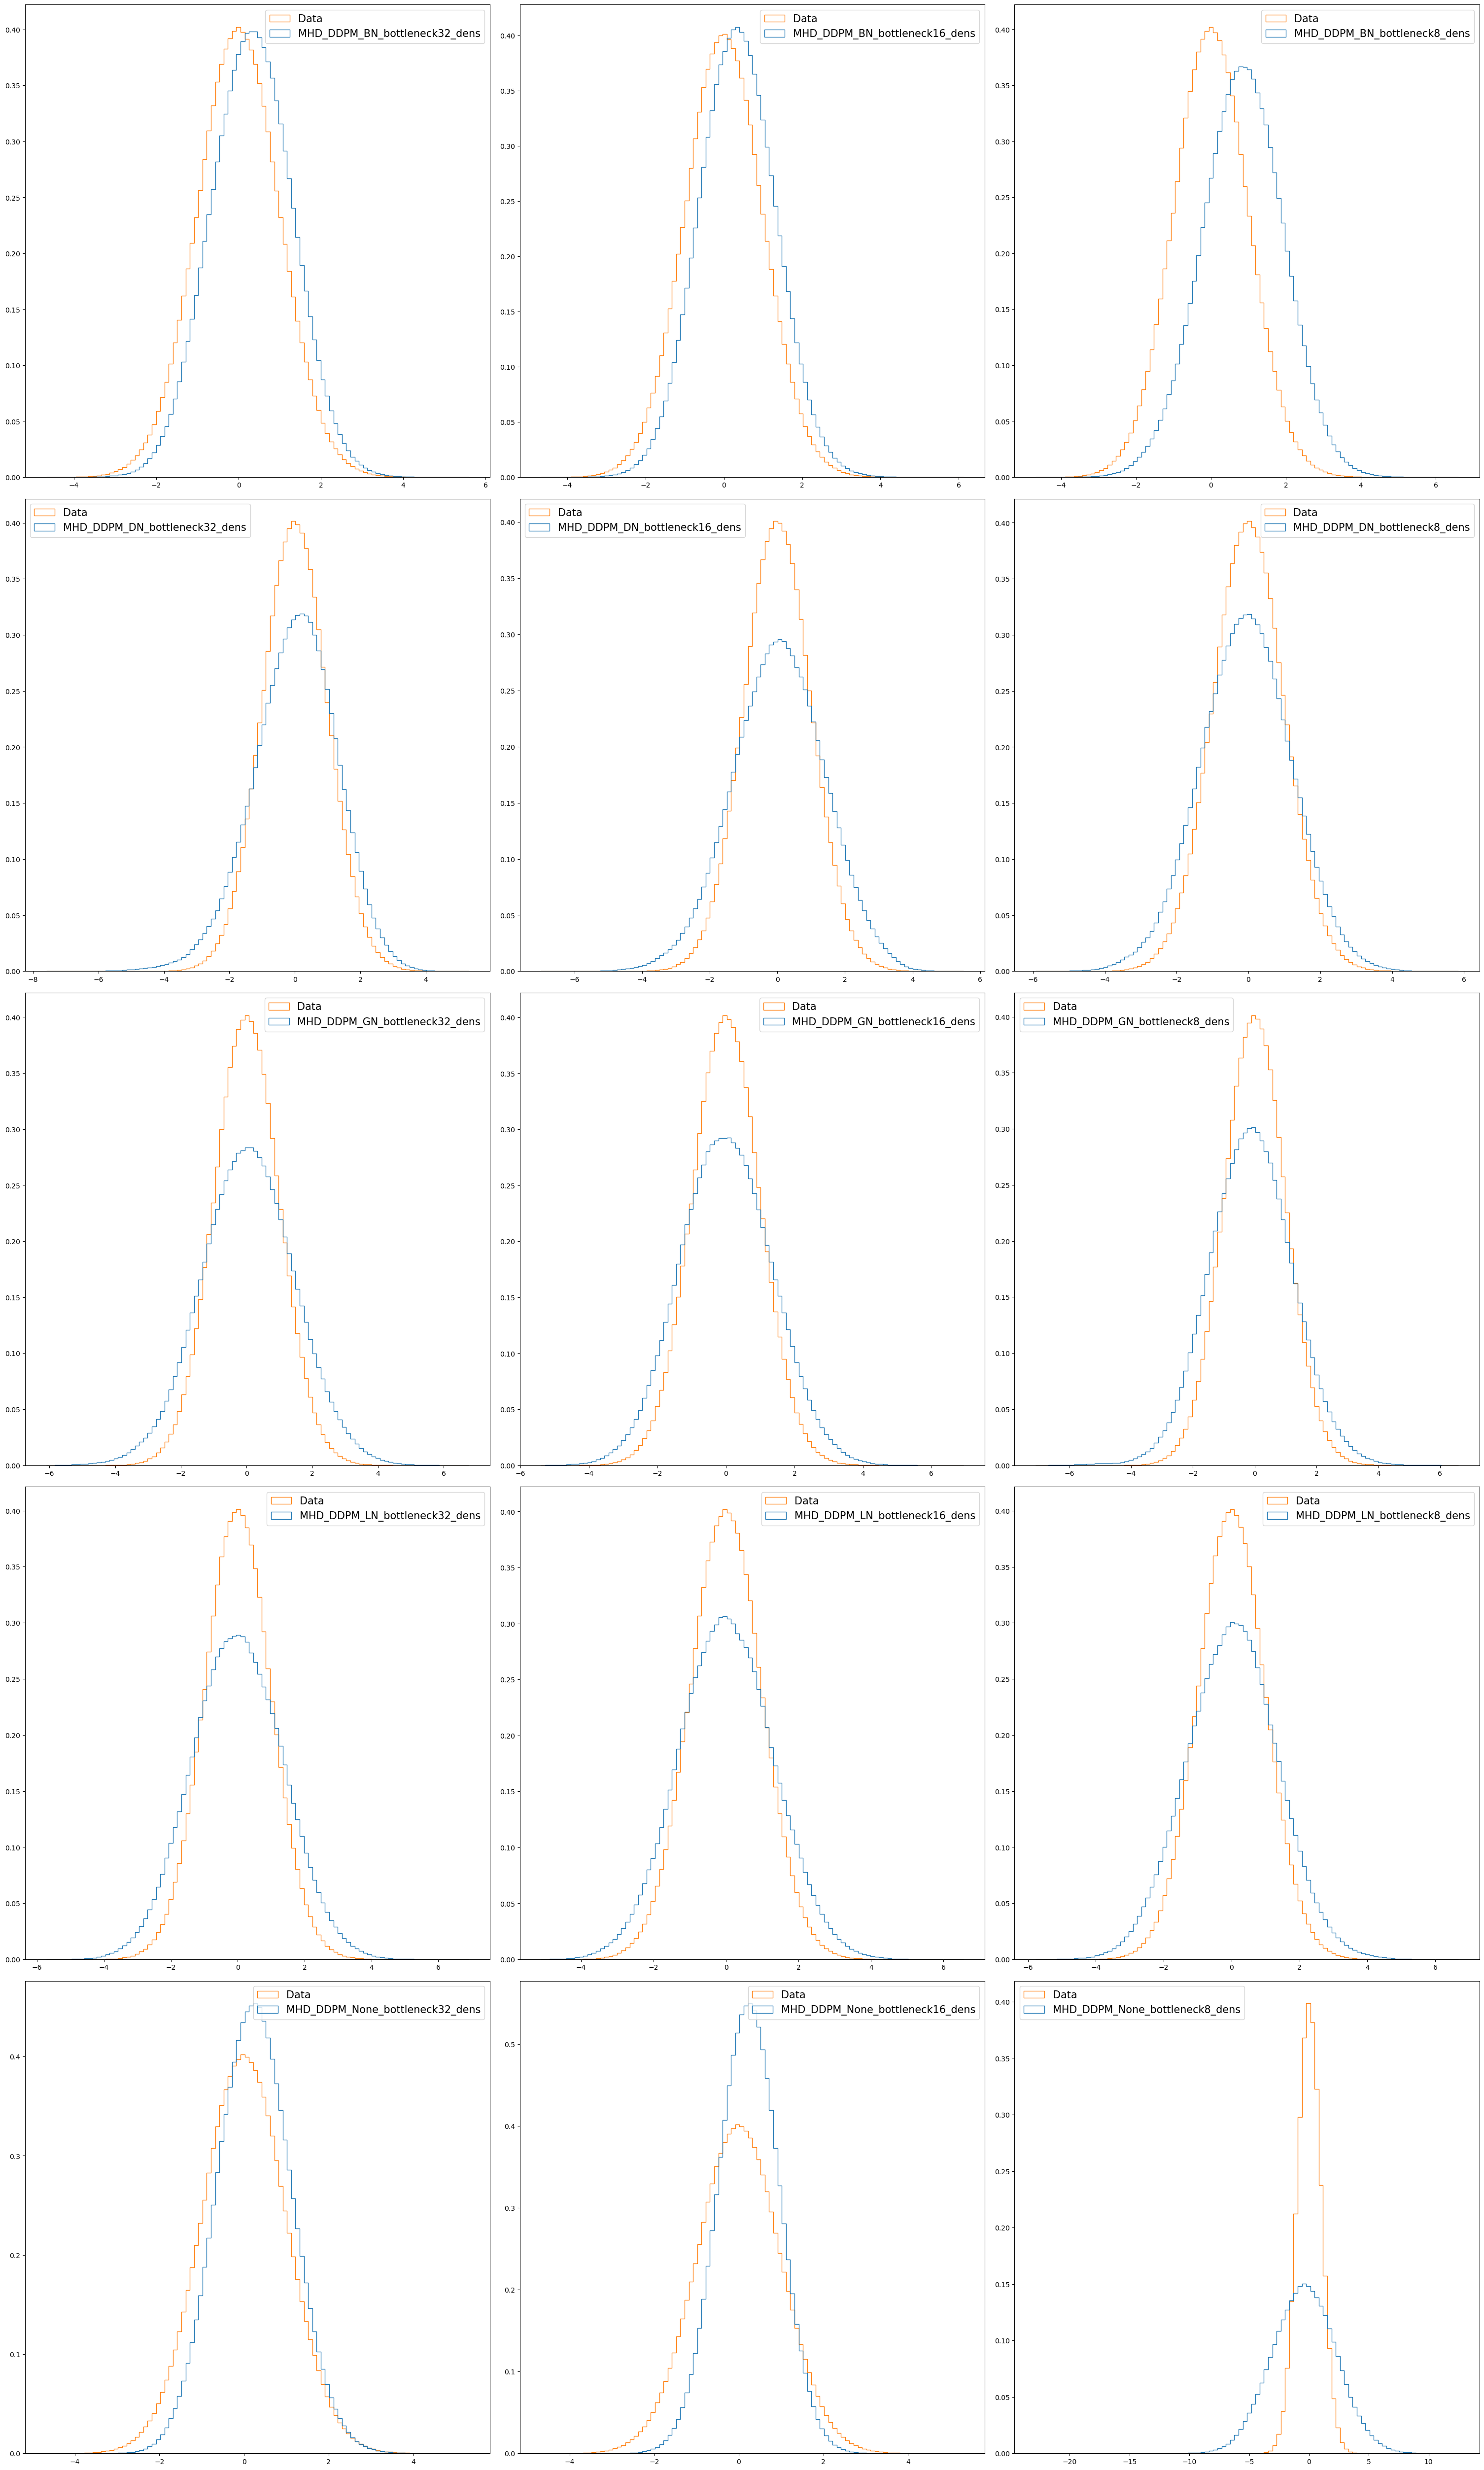

In [83]:
pdffig = PdfPages('/_pdf/hist_DDPM_toy.pdf')
fig = plt.figure(constrained_layout=True,figsize=(30,50))

axs = fig.subplots(nrows=5, ncols=3)
for col in range(3):
    for row in range(5):

        axs[row][col].hist([total_samples_data[col+row*3].flatten(), source_data_partial_toy.flatten()], label=[exps_to_check[col+row*3], 'Data'],density=True,histtype='step',bins=100)
        axs[row][col].legend(fontsize=15)

plt.savefig(pdffig, format='pdf')

metadata = pdffig.infodict()

metadata['Author'] = 'David Heurtel-Depeiges'
metadata['Subject'] = 'Histograms, DDPM with UNet, bottleneck 32, toy dataset, from top to bottom BatchNorm, DoubleNorm, GroupNorm, LayerNorm, None, Data, right to left 32, 16 and 8-sized bottleneck'

pdffig.close()